### Importing Necessary Libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
import warnings

### Loading and Reading the Dataset

In [3]:
# Load the dataset
df = pd.read_csv('../data/HAM10000_metadata.csv')

In [4]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [6]:
df.describe()

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


In [7]:
df.shape

(10015, 7)

### Data Preprocessing

In [8]:
df['dx'].unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

##### Make a dictionary for the images and its labels (convert to more interpretable labels)

In [9]:
# Dictionary for the different lesion types
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Define the base directory where the image data is stored.
base_skin_dir = os.path.join('..', 'data')

# Dictionary that maps each image ID 
imageid_path_dict = {

    # For each image file path 'x', extract the base name (file name without the directory path)
    os.path.splitext(os.path.basename(x))[0]: x

    # glob returns a list of file paths 
    for x in glob(os.path.join(base_skin_dir, 'HAM10000_images_part_1', '*.jpg')) + 
             glob(os.path.join(base_skin_dir, 'HAM10000_images_part_2', '*.jpg'))
}

# This dictionary will have keys that are the image IDs (e.g., 'ISIC_0024306')
# and values that are the full paths to the corresponding image files (e.g., '../data/HAM10000_images_part_1/ISIC_0024306.jpg').

##### Add columns to df using the dictionary values

In [10]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,..\data\HAM10000_images_part_1\ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,..\data\HAM10000_images_part_1\ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,..\data\HAM10000_images_part_1\ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,..\data\HAM10000_images_part_1\ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,..\data\HAM10000_images_part_2\ISIC_0031633.jpg,Benign keratosis-like lesions,2


##### Data Cleaning

In [11]:
df.isna().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [12]:
# Instead of dropping the 57 null values, we could just get the mean and fill the null values
df['age'] = df['age'].fillna(df['age'].mean())

In [13]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [14]:
df['age'] = df['age'].astype(int)

##### Image Processing
- Why Resize Images?
   + CNNs require input images to be of a fixed size
   + Larger images require more memory and computational power
- Let's resize the original dimensions of   450px x 600px   to   **125px x 100px**

In [15]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((125,100))))

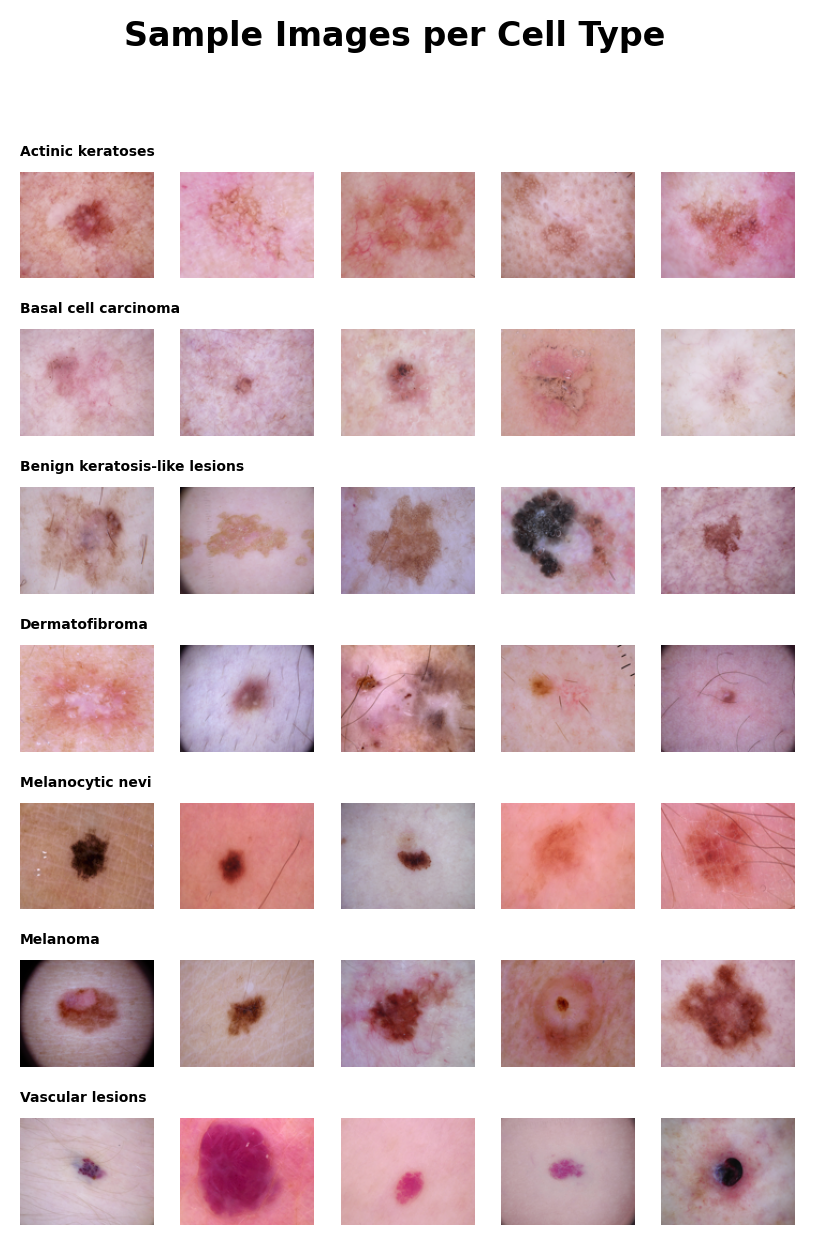

In [16]:
samples_per_row = 5

# Create a subplot grid with 7 rows and 4 columns
fig, m_axs = plt.subplots(7, samples_per_row, figsize=(5,7), dpi=200)

fig.suptitle('Sample Images per Cell Type', fontsize=12, fontweight='bold')

for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         df.sort_values(['cell_type']).groupby('cell_type')):
    
    # Set title of the first subplot in each row to the category name
    n_axs[0].set_title(type_name, fontsize=5, fontweight='bold', loc='left')
    
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(samples_per_row, random_state=1150).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')    

plt.show()

### Exploratory Data Analysis

In [17]:
df= df[df['age'] != 0]
df= df[df['sex'] != 'unknown']

##### Single-Variable Analysis

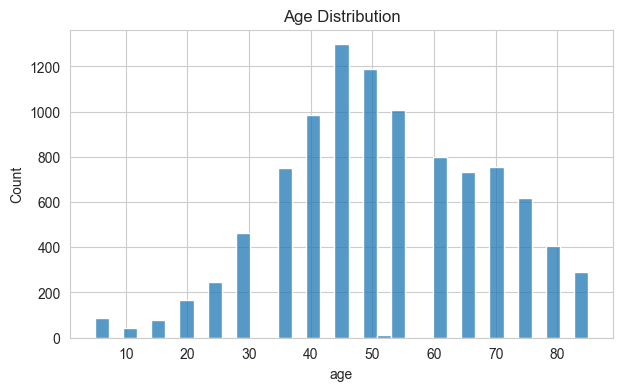

In [18]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(7,4))
ax = sns.histplot(data=df, x='age')
plt.title('Age Distribution')
plt.show()

- The highest frequency of individuals falls within the age range of 40 to 45 years old
- The probability of having skin cancer increases as age increases

In [19]:
# Function to plot df horizontally
def plot_horizontal_bar(df, column, title, figsize=(7, 4), palette='Spectral'):
    plt.figure(figsize=figsize) 
    plt.title(title, fontsize=15)  
    plt.xlabel("Count")
    
    value_counts = df[column].value_counts()
    
    sns.barplot(x=value_counts.values, 
                y=value_counts.index, 
                palette=palette,
                hue=value_counts.index, 
                legend=False) 
    
    plt.tight_layout()

    plt.show()

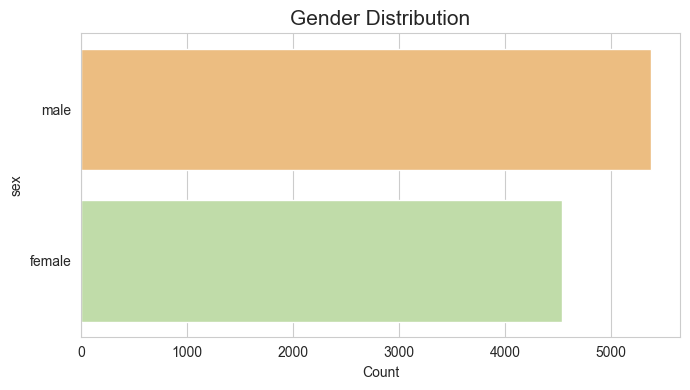

In [20]:
plot_horizontal_bar(df, 'sex', 'Gender Distribution')

- Skin cancer is more prominent in males than females

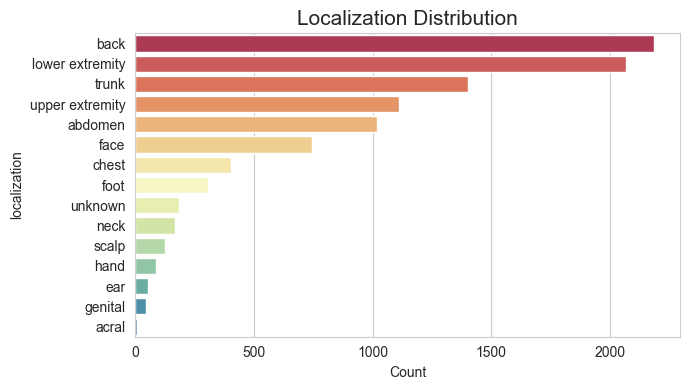

In [21]:
plot_horizontal_bar(df, 'localization', 'Localization Distribution')

- It appears that skin cancer lesions are most prevalent on the back and lower extremities This suggests that these areas are more susceptible to the development of skin cancer, possibly due to increased sun exposure.
- Other body parts with a significant number of lesions include the trunk and upper extremities.
- While less frequent, lesions are also observed on the head and neck, as well as the torso.
- It's important to note that the graph seems to indicate a lower incidence of lesions on areas like the palms, soles, and nails. This could be due to lower sun exposure or other factors influencing skin cancer development in these regions.

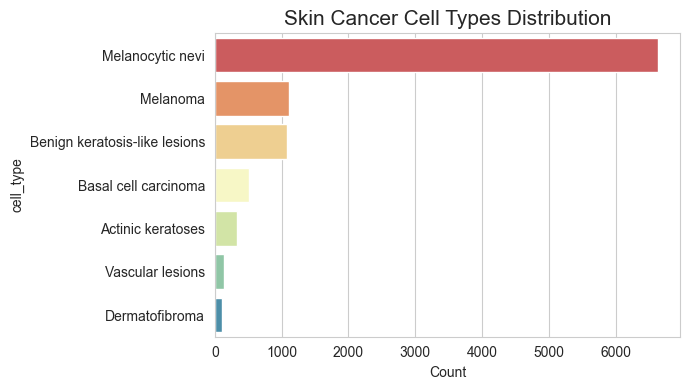

In [22]:
plot_horizontal_bar(df, 'cell_type', 'Skin Cancer Cell Types Distribution')

- Melanocytic nevi is the most prevalent cell type while Vascular lesions and dermatofibroma are the least represented cell types in the dataset.

##### Cross-Variable Analysis

In [23]:
# Function for two variable count bar plot
def plot_countplot(df, x_col, hue_col, title, palette='Set2', figsize=(9, 6)):
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(figsize=figsize)
    count_plot = sns.countplot(x=x_col,
                               hue=hue_col,
                               data=df,
                               order=df[x_col].value_counts().index,
                               palette=palette,
                               ax=ax)


    plt.title(title)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

In [24]:
# Function for two variable stacked bar plot
def plot_stacked_bar(df, x_col, hue_col, title, palette='Set2', figsize=(9, 6)):
    sns.set_style('whitegrid')

    aggregated_data = df.groupby([x_col, hue_col]).size().unstack(fill_value=0)

    fig, ax = plt.subplots(figsize=figsize)
    
    aggregated_data.plot(kind='bar', stacked=True, colormap=palette, ax=ax)

    plt.title(title)
    plt.xlabel(x_col.capitalize())
    plt.ylabel("Count")
    plt.xticks(rotation=45)

    plt.legend(title=hue_col.capitalize(), bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    
    plt.show()

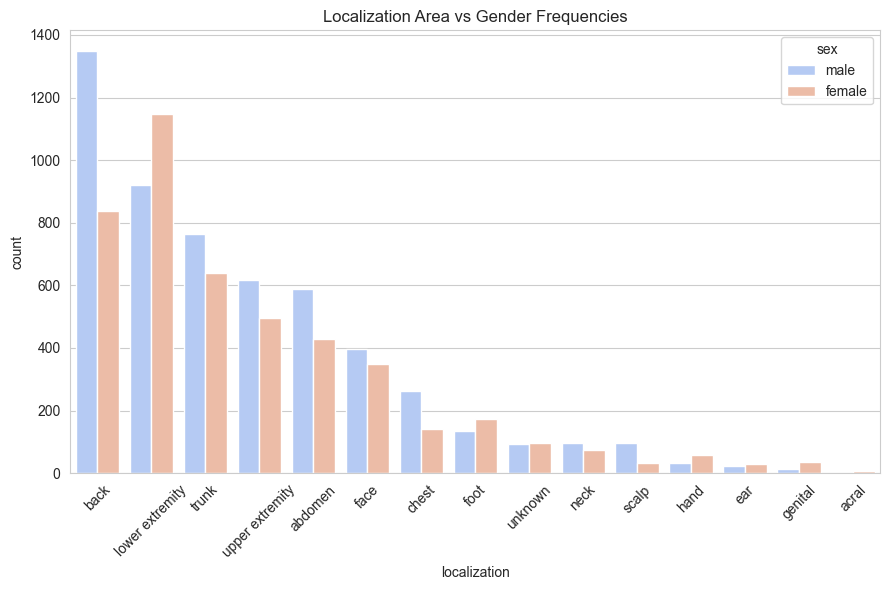

In [25]:
plot_countplot(df, x_col='localization', hue_col='sex', title='Localization Area vs Gender Frequencies', palette='coolwarm')

- Males tend to have a higher frequency of lesions on the back, trunk, and upper extremities compared to females. Females, on the other hand, exhibit a slightly higher frequency of lesions on the lower extremities and abdomen.

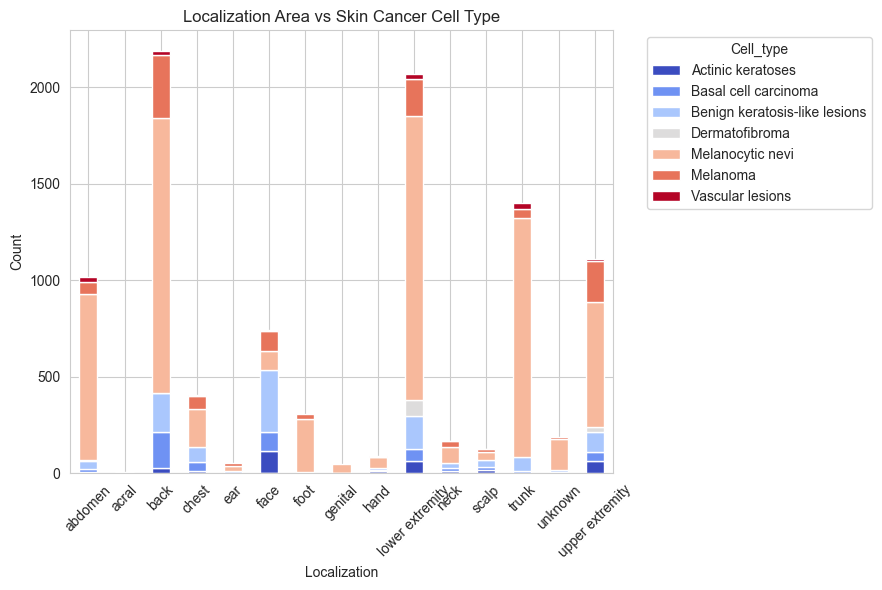

In [26]:
plot_stacked_bar(df, x_col='localization', hue_col='cell_type', title='Localization Area vs Skin Cancer Cell Type', palette='coolwarm')

- Melanocytic nevi is the most prevalent cell type across most localization areas, with particularly high counts on the back, lower extremity, and trunk.
- Actinic keratoses and basal cell carcinoma are frequently observed on the head and neck regions (face, ear, scalp).

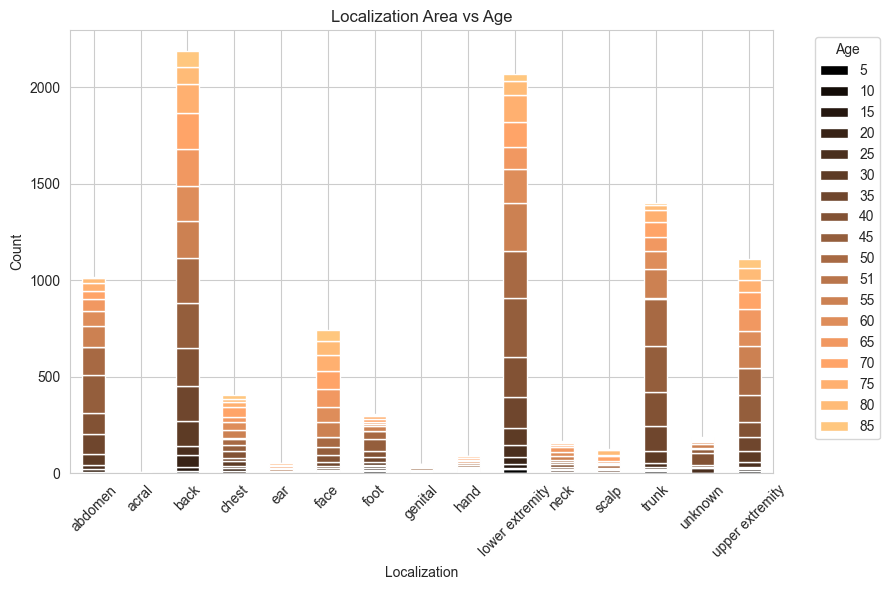

In [27]:
plot_stacked_bar(df, x_col='localization', hue_col='age', title='Localization Area vs Age', palette='copper')

- There seem to be peaks in lesion counts for certain age groups in specific localization areas. For example, the back and trunk show higher counts in the 40-50 age range.
- The distribution of ages varies across different localization areas. Some areas, like the face and scalp, have a more even distribution of ages, while others, like the lower extremity, show a concentration in younger age groups.

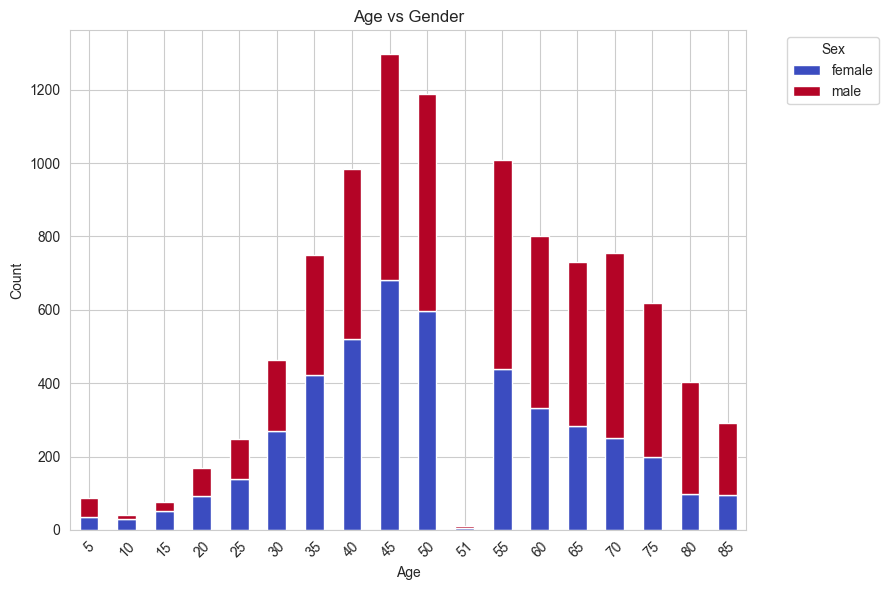

In [28]:
plot_stacked_bar(df, x_col='age', hue_col='sex', title='Age vs Gender', palette='coolwarm')

- The graph shows a higher number of females in younger age groups (10-30 years old).
- There's a clear shift towards a higher number of males in older age groups (50+ years old).

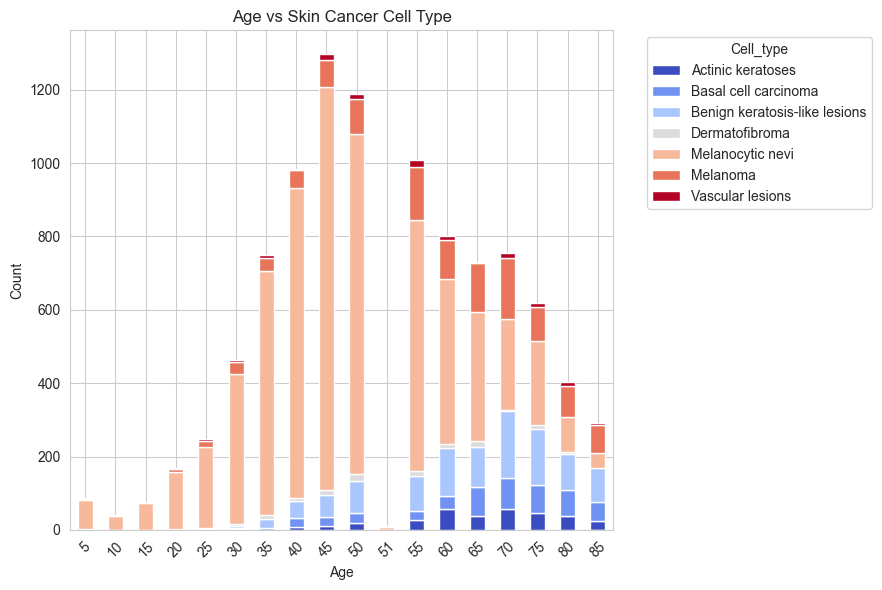

In [29]:
plot_stacked_bar(df, x_col='age', hue_col='cell_type', title='Age vs Skin Cancer Cell Type', palette='coolwarm')

- Melanocytic nevi are the most prevalent cell type across all age groups, with a significant peak in the 40-50 age range.
- Actinic keratoses and basal cell carcinoma show a gradual increase with age, becoming more common in older populations
- Benign keratosis-like lesions are more frequent in middle-aged individuals (40-60).
- Dermatofibroma has a relatively stable distribution across age groups.
- Melanoma shows a slight increase with age, with a peak around 50-60.
- Vascular lesions are less common and exhibit no clear age-related pattern

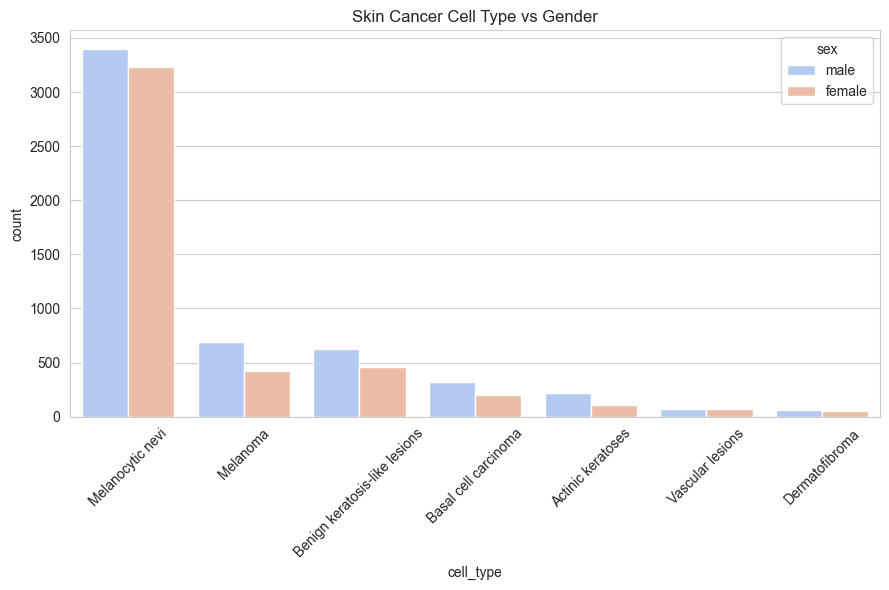

In [30]:
plot_countplot(df, x_col='cell_type', hue_col='sex', title='Skin Cancer Cell Type vs Gender', palette='coolwarm')

- Melanocytic nevi is the most common cell type for both males and females, with a significantly higher count in males.
- Melanoma is also more prevalent in males compared to females.   
- For cell types such as benign keratosis-like lesions, basal cell carcinoma, actinic keratoses, vascular lesions, and dermatofibroma, there appears to be a higher prevalence in males, though the differences are less pronounced compared to melanocytic nevi and melanoma.